In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import torch
!nvidia-smi
torch.cuda.is_available()

Fri Nov 18 10:32:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

Ноутбук делался на кагде потому что в гугл колабе постоянно что то падало с ГПУ

In [4]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()                           


  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=da1c4b56c1ddf1dbf0cb783b729bfe8e9223b6b49bda32c2d38c2249ea5f2e1c
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil
^C
Traceback (most recent call last):
  File "/opt/conda/bin/pip", line 10, in <module>
    sys.exit(main())
  File "/opt/conda/lib/python3.7/site-packages/pip/_internal/cli/main.py", line 70, in main
    return command.main(cmd_args)
  File "/opt/conda/lib/python3.7/site-packages/pip/_internal/cli/base_command.py", line 101, in main
    return self._main(args)
  File "/opt/conda/lib/python3.7/site-packages/pip/_internal/cli/base_command.py", line 223, in _main
    self.handle_pip_version_check(options)
  File "/opt/conda/lib/python3.7/site-packages/pip/_internal/cli/req_command.py", line 148, in handle_pip_version_check
    pip_self_version_check(session, options)
  F

In [5]:
import pickle
import numpy as np
import pandas as pd
from skimage import io
import math
import random

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, models
from torchvision.utils import save_image
from torch.optim import lr_scheduler




from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [6]:
import shutil

src_path = '../input/journey-springfield/train'
dst_path = './my_fol'
shutil.copytree(src_path, dst_path)


#train_dir = Path('./train/simpsons_dataset')




#train_val_files = sorted(list(train_dir.rglob('*.jpg')))

#train_val_labels = [path.parent.name for path in train_val_files]

'./my_fol'

In [7]:
train_dir = Path('./my_fol/simpsons_dataset')




train_val_files = sorted(list(train_dir.rglob('*.jpg')))

train_val_labels = [path.parent.name for path in train_val_files]

In [8]:
df = pd.DataFrame({"labels" : train_val_labels}).value_counts().rename_axis('unique_values').to_frame('counts')
df = df.reset_index().set_index('unique_values')
df

,counts
unique_values,
homer_simpson,2246
ned_flanders,1454
moe_szyslak,1452
lisa_simpson,1354
bart_simpson,1342
marge_simpson,1291
krusty_the_clown,1206
principal_skinner,1194
charles_montgomery_burns,1193


увеличен размер выборки и проведены всякие агументации 

In [10]:
df['to_add'] = df['counts'].apply(lambda x: 1000 - x if x < 1000 else 0)
df['one_iteration'] = df.apply(lambda x: math.ceil(x['to_add'] / x['counts']), axis=1)
df
# to_add - сколько добавить до 1000 , one_iteration - сколько раз пройтись циклом по данным

,counts,to_add,one_iteration
unique_values,,,
homer_simpson,2246,0,0
ned_flanders,1454,0,0
moe_szyslak,1452,0,0
lisa_simpson,1354,0,0
bart_simpson,1342,0,0
marge_simpson,1291,0,0
krusty_the_clown,1206,0,0
principal_skinner,1194,0,0
charles_montgomery_burns,1193,0,0


In [11]:
augmenters = {
    'Crop': transforms.Compose([
                                transforms.Resize(size=300, max_size=301),
                                transforms.CenterCrop(size=300),
                                transforms.RandomCrop(250)
                                ]),
    'Rotate': transforms.RandomRotation(degrees=(-45, 45)),
    'HFlip': transforms.RandomHorizontalFlip(p=1)
}

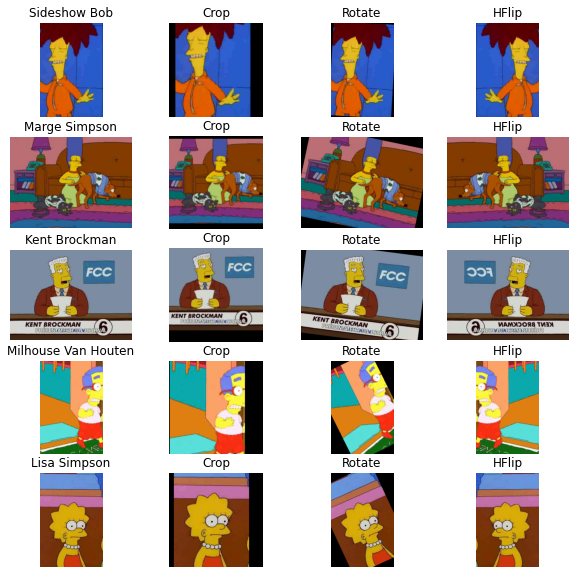

In [12]:
n_examples = 5

fig, ax = plt.subplots(nrows=n_examples, ncols=(len(augmenters) + 1),figsize=(10, 10))

for i in range(n_examples):
    random_character = int(np.random.uniform(0, len(train_val_files)))
    img_path = train_val_files[random_character]


    img_orig = Image.open(img_path)
    img_orig.load()

    img_label = train_val_files[random_character].parent.name

    img_label = " ".join(map(lambda x: x.capitalize(),\
                img_label.split('_')))
    ax[i][0].imshow(img_orig)
    ax[i][0].set_title(img_label)
    ax[i][0].axis('off')
        
    for j, (augmenter_name, augmenter) in enumerate(augmenters.items()):
        img_aug = augmenter(img_orig)
        ax[i][j + 1].imshow(img_aug)
        ax[i][j + 1].set_title(augmenter_name)
        ax[i][j + 1].axis('off')

In [13]:
for image_path in tqdm(train_val_files):
    path = image_path.parents[0]
    character = image_path.parent.name


    img = Image.open(image_path)
    img.load()
    # if we don't need to add any images, we can continue without transformation
    if df.loc[character]['to_add'] <= 0:
        continue
    if df.loc[character]['one_iteration'] > df.loc[character]['to_add']:
        iter_size = df.loc[character]['to_add']
    else:
        iter_size = df.loc[character]['one_iteration']
    df.loc[character]['to_add'] -= iter_size
    for i in range(iter_size):
        augmenter = random.choice(list(augmenters.values()))
        aug_img = augmenter(img)
        aug_img.save(f"{path}/{image_path.name.split('.')[0]}_{i}.jpg")

100%|██████████| 20933/20933 [02:46<00:00, 125.81it/s]


In [14]:
train_dir = Path('./my_fol/simpsons_dataset')
train_val_files = sorted(list(train_dir.rglob('*.jpg')))

train_val_labels = [path.parent.name for path in train_val_files]

df = pd.DataFrame({"labels" : train_val_labels}).value_counts().rename_axis('unique_values').to_frame('counts')
df = df.reset_index().set_index('unique_values')
df

,counts
unique_values,
homer_simpson,2246
ned_flanders,1454
moe_szyslak,1452
lisa_simpson,1354
bart_simpson,1342
marge_simpson,1291
krusty_the_clown,1206
principal_skinner,1194
charles_montgomery_burns,1193


In [15]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [16]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [17]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [18]:
TRAIN_DIR = Path('./my_fol/simpsons_dataset')
TEST_DIR = Path("../input/journey-springfield/testset")

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [19]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [20]:
val_dataset = SimpsonsDataset(val_files, mode='val')

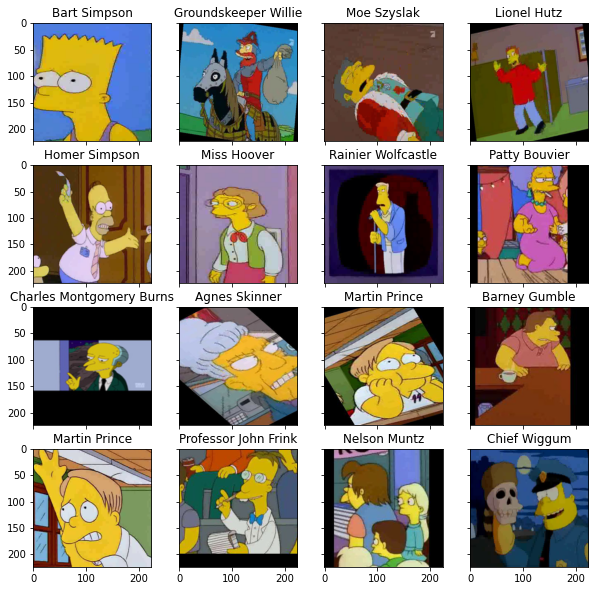

In [21]:
fig, ax = plt.subplots(nrows=4, ncols=4,figsize=(10, 10), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,10000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

решил попробовать mobilenet_v2 До этого пробовал Alex и Res, результаты не очень понравились 

In [22]:
class Classifier(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()    
        self.encoder = models.mobilenet_v2(pretrained = True).features   
        self.linear_classifier = torch.nn.Linear(1280, num_classes)    # Отрезаем голову нашему отцовскому классификатору и вставляем наши 42 класса
                                                                                        
    def forward(self, sample):
        final_feature_map = self.encoder(sample)    # Все слои и прочая муть от мобайлнета (backbone тоже разрешён)
        pooled_features = nn.functional.adaptive_avg_pool2d(final_feature_map, (1, 1))    # Объединяем слои
        flatten_features = torch.flatten(pooled_features, 1)
        logits = self.linear_classifier(flatten_features)  
        return logits

In [23]:
n_classes = len(np.unique(train_val_labels))
model = Classifier(n_classes).to(DEVICE)


print(model)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

Classifier(
  (encoder): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, m

In [24]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [25]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    return val_loss, val_acc

In [26]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr=3e-4)
        criterion = nn.CrossEntropyLoss()
        scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1, verbose = True)
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            scheduler.step()
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [27]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [28]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [29]:
history = train(train_dataset, val_dataset, model=model, epochs=30, batch_size=32)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.
loss 0.3695782104349763


epoch:   5%|▌         | 1/20 [06:00<1:54:17, 360.95s/it]

Adjusting learning rate of group 0 to 3.0000e-04.

Epoch 001 train_loss: 0.3696     val_loss 0.0999 train_acc 0.9158 val_acc 0.9746
loss 0.26949018574766437


epoch:  10%|█         | 2/20 [11:53<1:46:47, 355.99s/it]

Adjusting learning rate of group 0 to 3.0000e-04.

Epoch 002 train_loss: 0.2695     val_loss 0.1268 train_acc 0.9287 val_acc 0.9646
loss 0.11270994029047265


epoch:  15%|█▌        | 3/20 [17:43<1:40:02, 353.10s/it]

Adjusting learning rate of group 0 to 3.0000e-04.

Epoch 003 train_loss: 0.1127     val_loss 0.1487 train_acc 0.9684 val_acc 0.9613
loss 0.08870003476755302


epoch:  20%|██        | 4/20 [23:32<1:33:45, 351.59s/it]

Adjusting learning rate of group 0 to 3.0000e-04.

Epoch 004 train_loss: 0.0887     val_loss 0.1004 train_acc 0.9764 val_acc 0.9729
loss 0.08692671478897228


epoch:  25%|██▌       | 5/20 [29:22<1:27:45, 351.04s/it]

Adjusting learning rate of group 0 to 3.0000e-04.

Epoch 005 train_loss: 0.0869     val_loss 0.1147 train_acc 0.9755 val_acc 0.9695
loss 0.07849605414620985


epoch:  30%|███       | 6/20 [35:14<1:21:59, 351.42s/it]

Adjusting learning rate of group 0 to 3.0000e-04.

Epoch 006 train_loss: 0.0785     val_loss 0.1228 train_acc 0.9782 val_acc 0.9672
loss 0.07200419598459375


epoch:  35%|███▌      | 7/20 [41:05<1:16:07, 351.35s/it]

Adjusting learning rate of group 0 to 3.0000e-05.

Epoch 007 train_loss: 0.0720     val_loss 0.1265 train_acc 0.9795 val_acc 0.9669
loss 0.01305262657022227


epoch:  40%|████      | 8/20 [46:55<1:10:11, 350.94s/it]

Adjusting learning rate of group 0 to 3.0000e-05.

Epoch 008 train_loss: 0.0131     val_loss 0.0464 train_acc 0.9971 val_acc 0.9890
loss 0.0056220333734484755


epoch:  45%|████▌     | 9/20 [52:46<1:04:18, 350.81s/it]

Adjusting learning rate of group 0 to 3.0000e-05.

Epoch 009 train_loss: 0.0056     val_loss 0.0466 train_acc 0.9990 val_acc 0.9893
loss 0.003481595446253043


epoch:  50%|█████     | 10/20 [58:37<58:27, 350.77s/it] 

Adjusting learning rate of group 0 to 3.0000e-05.

Epoch 010 train_loss: 0.0035     val_loss 0.0467 train_acc 0.9994 val_acc 0.9893
loss 0.0023872050669518645


epoch:  55%|█████▌    | 11/20 [1:04:29<52:41, 351.30s/it]

Adjusting learning rate of group 0 to 3.0000e-05.

Epoch 011 train_loss: 0.0024     val_loss 0.0499 train_acc 0.9996 val_acc 0.9894
loss 0.0014503771927901511


epoch:  60%|██████    | 12/20 [1:10:18<46:44, 350.62s/it]

Adjusting learning rate of group 0 to 3.0000e-05.

Epoch 012 train_loss: 0.0015     val_loss 0.0518 train_acc 0.9997 val_acc 0.9893
loss 0.0010435028758925579


epoch:  65%|██████▌   | 13/20 [1:16:07<40:50, 350.12s/it]

Adjusting learning rate of group 0 to 3.0000e-05.

Epoch 013 train_loss: 0.0010     val_loss 0.0508 train_acc 0.9998 val_acc 0.9898
loss 0.0009169455538919536


epoch:  70%|███████   | 14/20 [1:21:55<34:57, 349.58s/it]

Adjusting learning rate of group 0 to 3.0000e-06.

Epoch 014 train_loss: 0.0009     val_loss 0.0570 train_acc 0.9998 val_acc 0.9877
loss 0.0005808900329660336


epoch:  75%|███████▌  | 15/20 [1:27:45<29:08, 349.70s/it]

Adjusting learning rate of group 0 to 3.0000e-06.

Epoch 015 train_loss: 0.0006     val_loss 0.0497 train_acc 0.9999 val_acc 0.9900
loss 0.0003101712923901227


epoch:  80%|████████  | 16/20 [1:33:39<23:24, 351.01s/it]

Adjusting learning rate of group 0 to 3.0000e-06.

Epoch 016 train_loss: 0.0003     val_loss 0.0499 train_acc 0.9999 val_acc 0.9900
loss 0.00024495162706296626


epoch:  85%|████████▌ | 17/20 [1:39:31<17:33, 351.27s/it]

Adjusting learning rate of group 0 to 3.0000e-06.

Epoch 017 train_loss: 0.0002     val_loss 0.0503 train_acc 0.9999 val_acc 0.9899
loss 0.00020684911059648336


epoch:  90%|█████████ | 18/20 [1:45:23<11:42, 351.27s/it]

Adjusting learning rate of group 0 to 3.0000e-06.

Epoch 018 train_loss: 0.0002     val_loss 0.0508 train_acc 0.9999 val_acc 0.9899
loss 0.00017547807585741778


epoch:  95%|█████████▌| 19/20 [1:51:16<05:51, 351.84s/it]

Adjusting learning rate of group 0 to 3.0000e-06.

Epoch 019 train_loss: 0.0002     val_loss 0.0517 train_acc 0.9999 val_acc 0.9900
loss 0.00016121032185771304


epoch: 100%|██████████| 20/20 [1:57:05<00:00, 351.29s/it]

Adjusting learning rate of group 0 to 3.0000e-06.

Epoch 020 train_loss: 0.0002     val_loss 0.0521 train_acc 0.9999 val_acc 0.9900


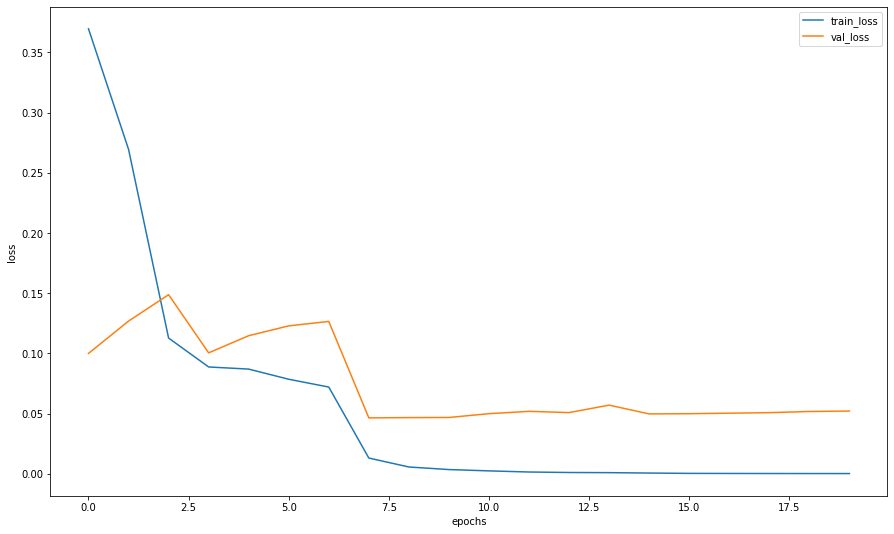

In [30]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [32]:
import numpy as np
idxs = list(map(int, np.random.uniform(0,10000, 500)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)


actual_labels = [val_dataset[id][1] for id in idxs]

y_pred = np.argmax(probs_ims,-1)

In [33]:
from sklearn.metrics import f1_score
f1_score(actual_labels, y_pred, average = 'weighted')

0.9909222156975287

результат более чем устраивает 

In [36]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))


test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=32)
probs = predict(model, test_loader)
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [38]:
submission = pd.read_csv('../input/journey-springfield/sample_submission.csv')
submission = pd.DataFrame({'Id': test_filenames, 'Expected': preds}).sort_values('Id')
submission.to_csv('sample_submission.csv', index=False)
